<div class="alert alert-block alert-info">
<b> What is this notebook/Lecture all about </b> 
 
Last lecture we actually trained the LLM model with the dataset. Below is what we performed.
1. We calculated the Loss
2. Started minimizing the Loss using backprogration
3. Updated the Weights of the model (defined in transformer Block , which was ~164M parameters)

After all this , we started using Model to perform some prediction of next input sequence.

Check the output below

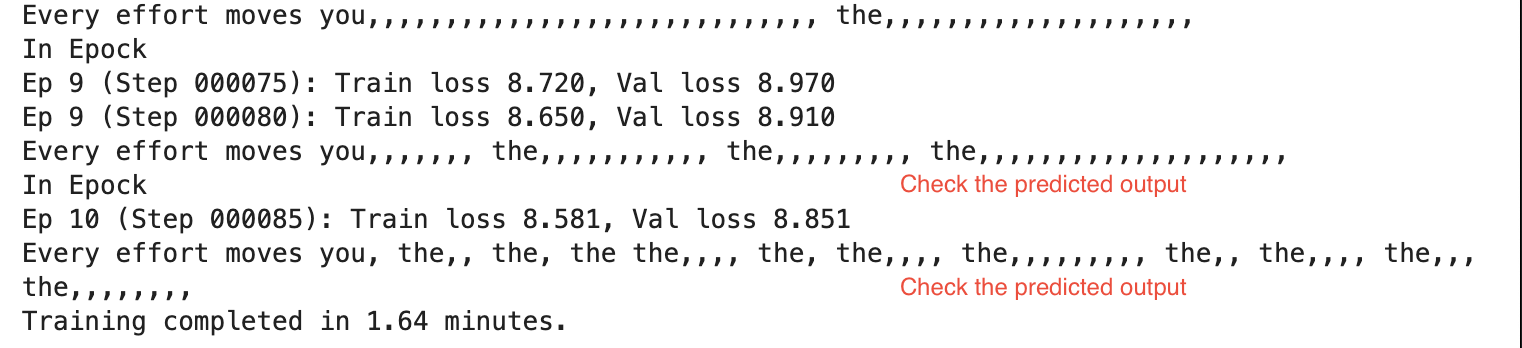

From the output of the LLM model , we see that the text that is generated is not what we really want. It actually doesnot make sense . 

So inorder to make the Model predict text/input sequence that are more contexually correct , we need some stratergy to control this random.

Meaning some way to make gthis predictions more meaningfull.

This lecture is all about understanding the strategies



</div>

<div class="alert alert-block alert-info">
<b> 2 Techniques to control the randomness of predictions </b> 
 
The 2 techniques use of improve the predictions are below

1. Temperature Scaling
2. Top K-sampling

We will be covering Temperature Scaling in this notebook

</div>

# Lets Learn Multinomial

<div class="alert alert-block alert-info">
<b> Lets see What is MultiNomial </b> 
 
After the Model is executed we generate Logits . 
This Logits is then passed through  the softmax function and then converts this logits score to probabilities.

Then to predict the next token we use <font color="red">argmax </font> to select the token with highest probability . This gives us the next token. , which is very determintistic.

<font color="red"> What if we change the approach :-</font>

What <font color="red"> instead of  argmax </font>  we select the next token from <font color="red"> sample of probability distribution </font>

This is the concept of temperature Scaling

</div>

<div class="alert alert-block alert-info">
<b> Multinomial </b> 
 
So now , we replace this ArgMax, and select the next token from sample of probability distribution . 

In Pytorch we have Multinominal probability distribution function to do this .

Multinominal probability distribution samples next token according to probability score
: "torch.multinomial"


Then to predict the next token we use <font color="red">argmax </font> to select the token with highest probability . This gives us the next token. , which is very determintistic.

<font color="red"> What if we change the approach :-</font>

What <font color="red"> instead of  argmax </font>  we select the next token from <font color="red"> sample of probability distribution </font>

This is the concept of temperature Scaling

</div>

<div class="alert alert-block alert-info">
<b> Let see example </b> 
 


</div>

In [9]:
# Lets define a samll vocab of size=9
# Inverse the vocab as well
vocab={
  "closer" :0,
  "every":  1,
  "efforts":2,
  "forward":3,
  "inches" :4,
  "moves"  :5,
  "pizza"  :6,
  "toward" :7,
  "you"    :8,
}

inverse_vocab = {v : k for k , v in vocab.items()}
print(inverse_vocab)

{0: 'closer', 1: 'every', 2: 'efforts', 3: 'forward', 4: 'inches', 5: 'moves', 6: 'pizza', 7: 'toward', 8: 'you'}


<div class="alert alert-block alert-info">
<p>

 Now we pass a input sequence = "every effort moves you" to the model
 
 The model will generate the Logist tensor as below
</p>
 


</div>

In [58]:
import torch
import torch.nn as nn

# The # of columns in logits matrix is equal to our vocab_size =9
# In the model we have a vocal_size=50257 

next_token_logits = torch.tensor (
    [4.51 , 0.89 , -1.90 , 6.75 , 1.63 , -1.62 , -1.89, 6.28 , 1.79 ]
)

<div class="alert alert-block alert-info">
<p>

 Now as per the presvious processwe pass this logits tensor to softmax , and then we use ArgMax to  get the next token. This will select the token with highest probability

Let us do the same process , as we do it 
</p>
 


</div>

In [57]:
probas =  torch.softmax(next_token_logits , dim=0)

print(probas)

next_predicted_token_id=torch.argmax(probas).item()

print(next_predicted_token_id)

print("Predicted next sequence:", inverse_vocab[next_predicted_token_id])

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])
3
Predicted next sequence: forward


<div class="alert alert-block alert-info">
<p>

Now lets apply the temperature scaling using multinomial probability distribution.

So we just replace ArgMax will be replaced with torch.multinomial
</p>
 


</div>

In [26]:
torch.manual_seed(123)
next_predicted_token_id= torch.multinomial(probas , num_samples=1).item()

print(next_predicted_token_id)

print("Predicted next sequence:", inverse_vocab[next_predicted_token_id])

3
Predicted next sequence: forward


<div class="alert alert-block alert-info">
<p>

The output is same as our original inmplementation , i.e like ArgMax.
However , multinomial samples from probabilities distribution after performing multiple trials.

Look below the explaination from Wiki

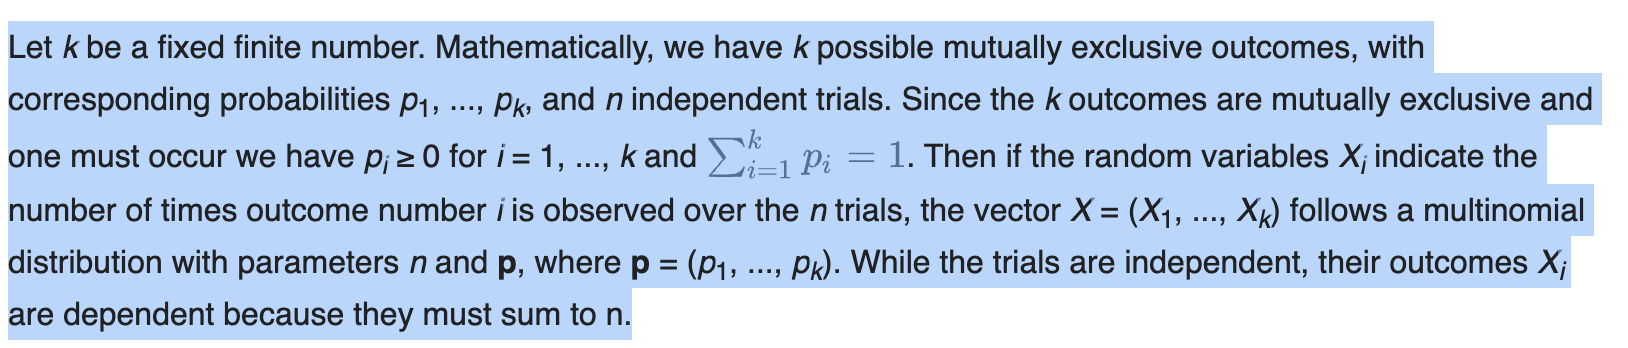

So lets try running it multiple times (1000) to see how it selects the output

</p>
 


</div>

In [53]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    samples = [torch.multinomial(probas , num_samples=1).item() for i in range(1000)]
    # samples = [ {"trail" : i, "token_id": torch.multinomial(probas , num_samples=1).item() } for i in range(1000)]
    # print(samples)
    occurence_samples_ids= torch.bincount(torch.tensor(samples))

    for token_id , counts in enumerate(occurence_samples_ids):
        print(f" {inverse_vocab[token_id]} was predicted {counts.item()} times")

    

In [54]:
print_sampled_tokens(probas)

 closer was predicted 73 times
 every was predicted 0 times
 efforts was predicted 0 times
 forward was predicted 582 times
 inches was predicted 2 times
 moves was predicted 0 times
 pizza was predicted 0 times
 toward was predicted 343 times


<div class="alert alert-block alert-info">
<p>


As per the explaination , multinomial provides a way for every token to appear or be predicted or be sampled 
based on its probabilitity distribution in a trial.

"forward" was predicted multiple time , so as "toward" , "closer" , "inches" got chances too to appear as next predicted token

</p>
 


</div>

<div class="alert alert-block alert-info">

As we can see based on the output, the word "forward" is sampled most of the time (582
out of 1000 times), but other tokens such as "closer", "inches", and "toward" will also
be sampled some of the time. 

This means that if we replaced the argmax function with the
multinomial function inside the generate_and_print_sample function, the LLM would
sometimes generate texts such as "every effort moves you toward", "every effort
moves you inches", and "every effort moves you closer" instead of "every effort
moves you forward".
    
</div>

<div class="alert alert-block alert-info">
<p>


SO with the temperature scaling , we improve the creativity of LLM .

Lower the temperature , more the model is determintistic (Example temperature = 0.1)

Higher the temperature value , more the LLM is creative/experimental (E.g temperature=5)

<font color="red"> Lets now understand what exactly temperature in this cntecxt mean ?? </font>

</p>
 


</div>

# Lets Learn what is temperature mean in LLM context

<div class="alert alert-block alert-info">
    <b> What does the Temperature here means </b>
<p>

Temperature : It is just a fancy term for dividing the logits tensore by a number that is greater then zero.

i.e     Scaled Logits  = Logits / Temperature (value greater than zero)

How Temperature Effect probability distributions :-

1. Temperature value is smaller :- Sharper the distribution
2. Temperature value is larger :- Flattened the distribution




</p>
 


</div>

<div class="alert alert-block alert-success">

Temperatures greater than 1 result in more uniformly distributed token probabilities,
and Temperatures smaller than 1 will result in more confident (sharper or more peaky)
distributions.

Let's illustrate this by plotting the original probabilities alongside
probabilities scaled with different temperature values:

</div>

In [66]:
def softmax_with_temperature(logits , temperature):
    scaled_logits = logits /temperature
    return torch.softmax(scaled_logits , dim=-1)

# we define the LLM confidence level with which it should be predicting
#Original , Higher confidence , and Lower confidence 
temperatures = [1, 0.1, 5] 

scaled_probas_with_temp = [softmax_with_temperature(next_token_logits , T) for T in temperatures ]

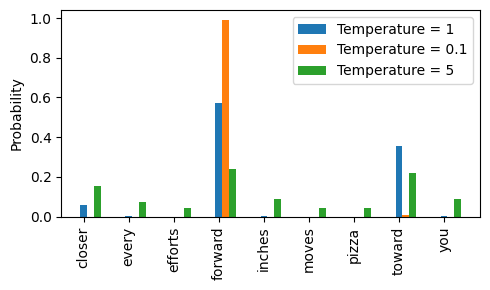

In [68]:
import matplotlib
import matplotlib_inline
import matplotlib.pyplot as plt

# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas_with_temp[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [71]:
# Lets look individually 
torch.set_printoptions(precision=10, sci_mode=False)

# WIth temperature lower value look at Probability distribution , it has very definative answer
print(torch.softmax((next_token_logits /0.1) , dim=-1)) 

tensor([    0.0000000002,     0.0000000000,     0.0000000000,     0.9909866452,
            0.0000000000,     0.0000000000,     0.0000000000,     0.0090133250,
            0.0000000000])


In [76]:
# WIth temperature higher value look at Probability distribution , it has increase probas of all tokensabs
# That can be appear in predictions

print(torch.softmax((next_token_logits /5) , dim=-1)) 

tensor([0.1546481699, 0.0749748424, 0.0429120474, 0.2420520186, 0.0869342908,
        0.0453836806, 0.0429979600, 0.2203357816, 0.0897611827])


<div class="alert alert-block alert-info">

A temperature of 1 divides the logits by 1 before passing them to the softmax function to
compute the probability scores. 

In other words, using a temperature of 1 is the same as not
using any temperature scaling. 

In this case, the tokens are selected with a probability equal
to the original softmax probability scores via the multinomial sampling function in PyTorch.    
</div>

<div class="alert alert-block alert-info">

Applying very small temperatures, such as 0.1, will
result in sharper distributions such that the behavior of the multinomial function selects
the most likely token (here: "forward") almost 100% of the time, approaching the
behavior of the argmax function. 

Vice versa, a temperature of 5 results in a more uniform
distribution where other tokens are selected more often. 

This can add more variety to the
generated texts but also more often results in nonsensical text. 

For example, using the
temperature of 5 results in texts such as "every effort moves you pizza" about 4% of
the time.
    
</div>

<div class="alert alert-block alert-info">

Read this for more details:-
    
https://medium.com/@harshit158/softmax-temperature-5492e4007f71    
    
</div>


# How do we apply use Temperature and Multinomial in what order

<div class="alert alert-block alert-info">

In nutshell , how temperature scaling workflow is as below.

1. Generate Logits matrix by passing input to Model.
2. Then scale the Logits by dividing it with temperature value to generate scaled_logits
3. Then pass the scaled_logits to softmax , to generate probabilities
4. Then apply the multinoimial to this scaled probability matrix for prediction

Just follow this sequential step and get this applied

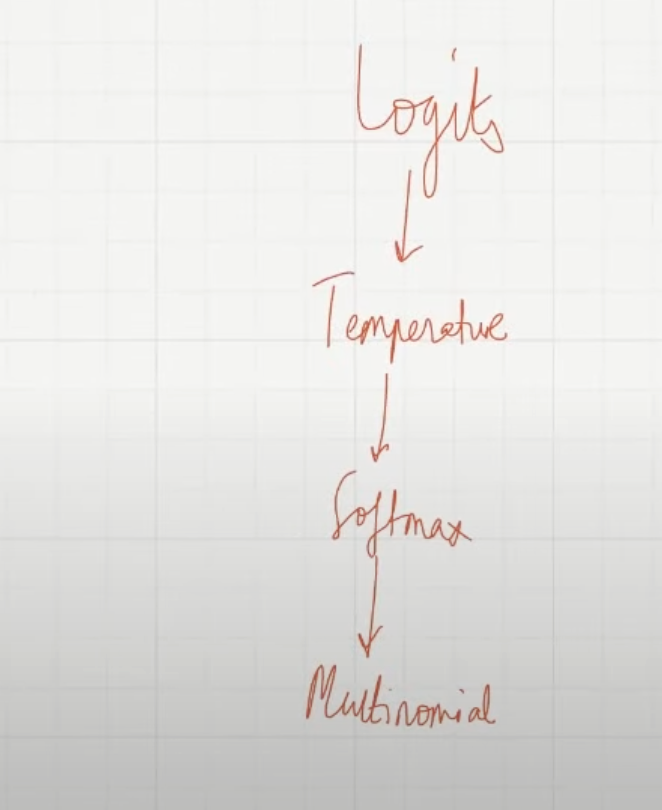
</div>


